## Logistic Regression : C++ vs scikit-learn

Dataset: `Social_Network_Ad_Logistic.csv`

### Environment setup (install dependencies)

This cell installs the required Python packages into the current environment. You usually run it once per environment.

In [4]:
!python -m pip install --quiet pybind11 numpy pandas seaborn scikit-learn jupyter nbconvert

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as SkLogistic
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import sys

# Resolve project root (handles running from repo root or src_notebook)
root = Path(".").resolve()
if not (root / "data").exists():
    root = root.parent

sys.path.append(str(root / "build"))


import shared_c_ext

%matplotlib inline
sns.set(style="whitegrid")

### Load data and basic EDA

Shape: (400, 5)


,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


,User ID,Gender,Age,EstimatedSalary,Purchased
count,4.000000e+02,400,400.000000,400.000000,400.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,204,NaN,NaN,NaN
mean,1.569154e+07,NaN,37.655000,69742.500000,0.357500
std,7.165832e+04,NaN,10.482877,34096.960282,0.479864
min,1.556669e+07,NaN,18.000000,15000.000000,0.000000
25%,1.562676e+07,NaN,29.750000,43000.000000,0.000000
50%,1.569434e+07,NaN,37.000000,70000.000000,0.000000
75%,1.575036e+07,NaN,46.000000,88000.000000,1.000000



Class balance (Purchased):
Purchased
0    0.6425
1    0.3575
Name: proportion, dtype: float64


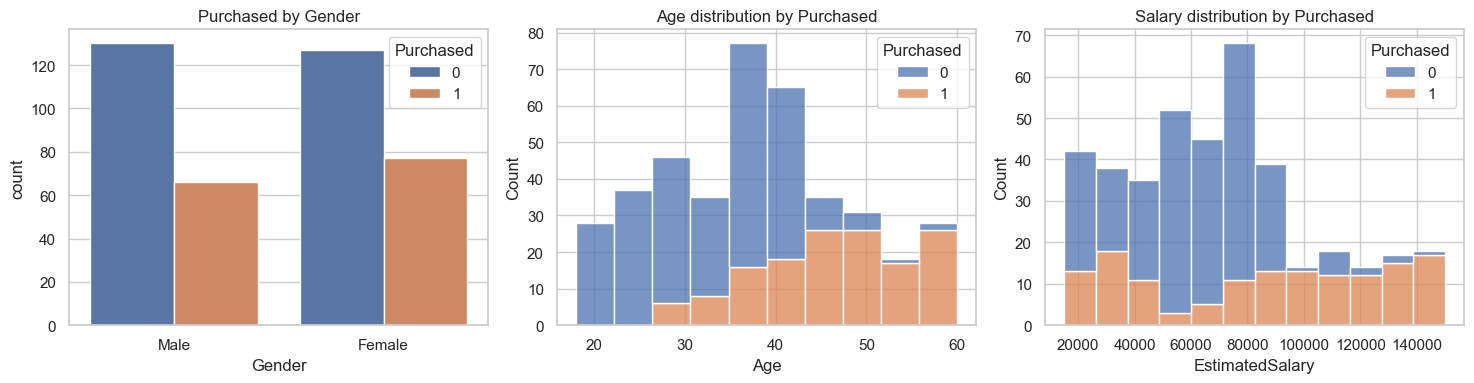

In [2]:
data_path = root / "data" / "Social_Network_Ad_Logistic.csv"
df = pd.read_csv(data_path)

print("Shape:", df.shape)
display(df.head())
display(df.describe(include="all"))
print("\nClass balance (Purchased):")
print(df["Purchased"].value_counts(normalize=True))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.countplot(x="Gender", hue="Purchased", data=df, ax=axes[0])
axes[0].set_title("Purchased by Gender")

sns.histplot(data=df, x="Age", hue="Purchased", multiple="stack", ax=axes[1])
axes[1].set_title("Age distribution by Purchased")

sns.histplot(data=df, x="EstimatedSalary", hue="Purchased", multiple="stack", ax=axes[2])
axes[2].set_title("Salary distribution by Purchased")

plt.tight_layout()
plt.show()

### Preprocess: drop ID, encode Gender as 0/1

In [3]:
# Map Gender to numeric: Female=0, Male=1
df["Gender_num"] = df["Gender"].map({"Female": 0, "Male": 1})

# Drop User ID and original Gender
df_model = df.drop(columns=["User ID", "Gender"])

display(df_model.head())

,Age,EstimatedSalary,Purchased,Gender_num
0,19,19000,0,1
1,35,20000,0,1
2,26,43000,0,0
3,27,57000,0,0
4,19,76000,0,1


### Train / test split and scaling

In [4]:
X = df_model[["Gender_num", "Age", "EstimatedSalary"]].values.astype(float)
y = df_model["Purchased"].values.astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:5], y_train[:5]

(array([[ 1.06649172, -0.95412576, -0.35403293],
        [-0.93765379,  0.36052204, -0.29658337],
        [ 1.06649172,  0.17271521,  1.48435309],
        [-0.93765379, -0.48460869,  1.34072919],
        [-0.93765379, -1.61144966, -1.35940029]]),
 array([0., 0., 1., 1., 0.]))

### Train C++ logistic regression (pybind) and sklearn logistic regression

In [6]:
# C++ logistic regression via pybind
cpp_model = shared_c_ext.LogisticRegression()
cpp_model.fit(X_train_scaled.tolist(), y_train.tolist(), epochs=1000)

cpp_probs = np.array([cpp_model.predict(row.tolist()) for row in X_test_scaled])
cpp_preds = (cpp_probs >= 0.5).astype(int)

# sklearn logistic regression
sk_model = SkLogistic(max_iter=1000)
sk_model.fit(X_train_scaled, y_train)
sk_probs = sk_model.predict_proba(X_test_scaled)[:, 1]
sk_preds = sk_model.predict(X_test_scaled)

cpp_acc = accuracy_score(y_test, cpp_preds)
sk_acc = accuracy_score(y_test, sk_preds)

print(f"C++ logistic accuracy: {cpp_acc:.4f}")
print(f"sklearn logistic accuracy: {sk_acc:.4f}")

C++ logistic accuracy: 0.8417
sklearn logistic accuracy: 0.8333


### Detailed comparison: confusion matrices and classification reports

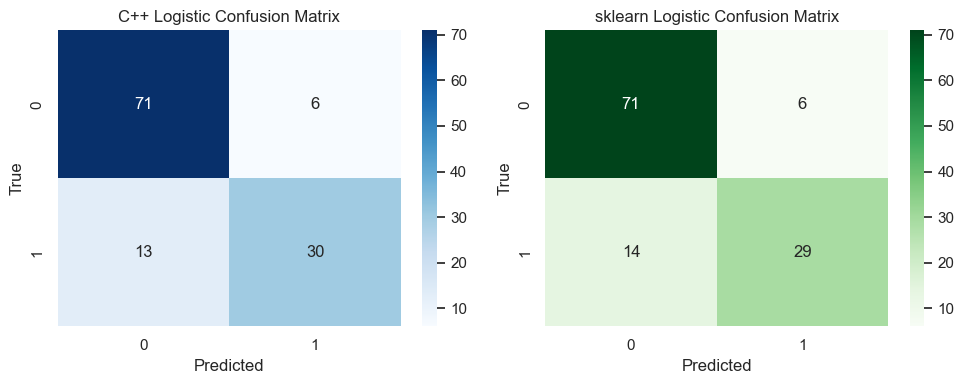

C++ classification report:
               precision    recall  f1-score   support

         0.0       0.85      0.92      0.88        77
         1.0       0.83      0.70      0.76        43

    accuracy                           0.84       120
   macro avg       0.84      0.81      0.82       120
weighted avg       0.84      0.84      0.84       120

sklearn classification report:
               precision    recall  f1-score   support

         0.0       0.84      0.92      0.88        77
         1.0       0.83      0.67      0.74        43

    accuracy                           0.83       120
   macro avg       0.83      0.80      0.81       120
weighted avg       0.83      0.83      0.83       120



In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

cm_cpp = confusion_matrix(y_test, cpp_preds)
cm_sk = confusion_matrix(y_test, sk_preds)

sns.heatmap(cm_cpp, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("C++ Logistic Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_sk, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("sklearn Logistic Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

print("C++ classification report:\n", classification_report(y_test, cpp_preds))
print("sklearn classification report:\n", classification_report(y_test, sk_preds))